# PyTorch Computer Vision using custom dataset


You can manually download **pizza-steak-sushi** with 3000 images from [here](https://www.kaggle.com/datasets/dietzschenostoevsky/pizza-steak-sushi?resource=download). Each category has 750 images for training and 250 images for testing. Be sure that you organize images in the following tree:
- data
    - pizza_steak_sushi
        - test
            - pizza
            - steak
            - sushi
        - train
            - pizza
            - steak
            - sushi

Or you can follow the steps below to automatically download the smaler dataset with 300 images and enjoy!



## 1. Import Libraries


In [1]:
import random
import os
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

import torchvision
from torchvision import datasets, transforms

from torch.utils.data import DataLoader
from torchinfo import summary
from torcheval.metrics.functional import (
    multiclass_accuracy,
    multiclass_confusion_matrix,
)
from mlxtend.plotting import plot_confusion_matrix

import engine
import utils

print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

RAMDOM_SEED = 42

%load_ext autoreload
%autoreload 2

torch: 2.2.0
torchvision: 0.17.0
device: cpu


## 2. Get Dataset


### 2.1 Downloading dataset from url


In [2]:
url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
data_dir = "pizza_steak_sushi"
image_dir = utils.download_dataset_from_url(url, data_dir)

data/pizza_steak_sushi directory exists.


### 2.2 Creating directories


In [3]:
train_dir = image_dir / "train"
test_dir = image_dir / "test"
image_path_list = list(image_dir.glob("*/*/*.jpg"))

print(f"image directory : {image_dir}")
print(f"train directory : {train_dir}")
print(f"test  directory : {test_dir}")
print(f"number of all images : {len(image_path_list)}")

image directory : data/pizza_steak_sushi
train directory : data/pizza_steak_sushi/train
test  directory : data/pizza_steak_sushi/test
number of all images : 3000


### 2.3 Visualizing the raw images


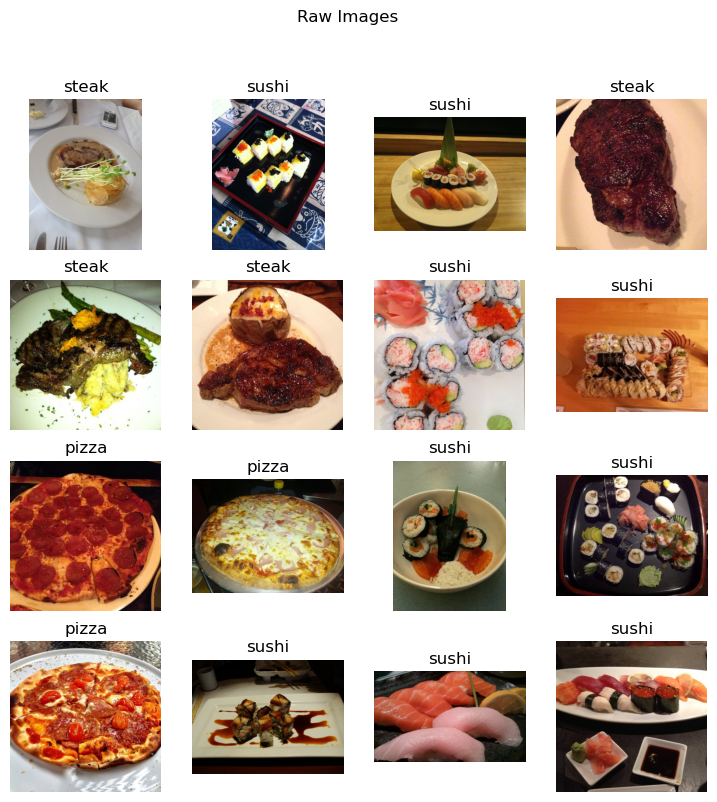

In [4]:
random.seed(RAMDOM_SEED)

rows, cols = 4, 4
random_image_paths = random.sample(image_path_list, k=rows*cols)

fig = plt.figure(figsize=(9, 9))
plt.suptitle("Raw Images")
plt.axis(False)
for i, image_path in enumerate(random_image_paths, start=1):
    label = image_path.parent.stem
    ax = fig.add_subplot(rows, cols, i)
    with Image.open(image_path) as img:
        plt.imshow(img)
    ax.set_title(label)
    ax.axis(False)

## 3. model 0


### 3.1 Creating transformation

In [5]:
transform_v0 = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ]
)

### 3.2 Creating `train_data_simple` and `test_data_simple`


In [6]:
train_data_v0 = datasets.ImageFolder(
    root=train_dir,
    transform=transform_v0,
)

test_data_v0 = datasets.ImageFolder(
    root=test_dir,
    transform=transform_v0,
)

In [7]:
print(f"train data: {len(train_data_v0)}")
print(f"test data : {len(test_data_v0)}")

class_names = train_data_v0.classes
NUM_CLASSES = len(class_names)
print(f"number of classes: {NUM_CLASSES}")
print(f"\nclass names:\n{class_names}")

class_to_idx = train_data_v0.class_to_idx
print(f"\nclass to index:\n{class_to_idx}")

targets = train_data_v0.targets
print(f"\nlength of targets:\n{len(targets)}")

image, label = train_data_v0[0]
INPUT_IMAGE_SIZE = image.shape
print(f"\nimage shape:\n{INPUT_IMAGE_SIZE} -> [color_channels, height, width]")
print(f"\nimage index label:\n{label}")
print(f"\nimage label:\n{class_names[label]}")

train data: 2250
test data : 750
number of classes: 3

class names:
['pizza', 'steak', 'sushi']

class to index:
{'pizza': 0, 'steak': 1, 'sushi': 2}

length of targets:
2250

image shape:
torch.Size([3, 64, 64]) -> [color_channels, height, width]

image index label:
0

image label:
pizza


### 3.3 Using `DataLoader()` to turn `train_data_v0` and `test_data_v0` into batches.


In [8]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_v0 = DataLoader(
    train_data_v0,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)

test_dataloader_v0 = DataLoader(
    test_data_v0,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

print(f"train dataloader: {train_dataloader_v0}")
print(f"test Dataloader : {test_dataloader_v0}")
print(
    f"length of train dataloader: {len(train_dataloader_v0)} batches of \
{BATCH_SIZE} ({len(train_dataloader_v0)*BATCH_SIZE})"
)
print(
    f"length of test dataloader : {len(test_dataloader_v0)} batches of \
{BATCH_SIZE} ({len(test_dataloader_v0)*BATCH_SIZE})"
)

Creating DataLoader's with batch size 32 and 4 workers.
train dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f8ebe324a00>
test Dataloader : <torch.utils.data.dataloader.DataLoader object at 0x7f8ebe345e70>
length of train dataloader: 71 batches of 32 (2272)
length of test dataloader : 24 batches of 32 (768)


### 3.4 Creating `SimpleCNN_V0`

In [9]:
class SimpleCNN_V0(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 3),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.classifier(x)
        return x

In [10]:
torch.manual_seed(42)

model_0 = SimpleCNN_V0().to(device)

summary(
    model_0,
    input_size=(BATCH_SIZE, 3, 64, 64),
    col_names=["input_size", "output_size", "num_params", "kernel_size", "trainable"],
    row_settings=["var_names"],
)

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Kernel Shape              Trainable
SimpleCNN_V0 (SimpleCNN_V0)              [32, 3, 64, 64]           [32, 3]                   --                        --                        True
├─Sequential (features)                  [32, 3, 64, 64]           [32, 64, 8, 8]            --                        --                        True
│    └─Conv2d (0)                        [32, 3, 64, 64]           [32, 16, 64, 64]          448                       [3, 3]                    True
│    └─BatchNorm2d (1)                   [32, 16, 64, 64]          [32, 16, 64, 64]          32                        --                        True
│    └─ReLU (2)                          [32, 16, 64, 64]          [32, 16, 64, 64]          --                        --                        --
│    └─MaxPool2d (3)                     [32, 16, 64, 64]          [32, 16, 32, 32]          --  

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
activation_fn = lambda x: torch.argmax(x, dim=1)

### 3.5 Train the model or load pre-trained state_dict


In [12]:
model_0.load_state_dict(torch.load(f="./models/model_0.pth"))
model_0_results = utils.load_model_results("./models/model_0.json")

In [13]:
# model_0_results = engine.train(
#     epochs=10,
#     model=model_0,
#     train_dataloader=train_dataloader_v0,
#     test_dataloader=test_dataloader_v0,
#     optimizer=optimizer,
#     loss_fn=loss_fn,
#     activation_fn=activation_fn,
#     accuracy_fn=multiclass_accuracy,
#     device=device,
# )

### 3.6 Plot loss and accuracy curves


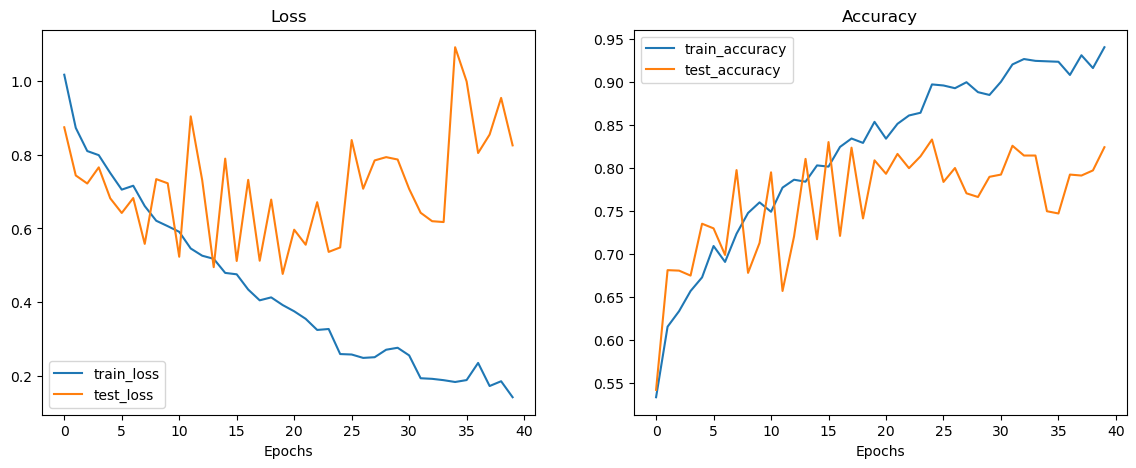

In [14]:
utils.plot_loss_curves(model_0_results, figsize=(14, 5))

### 3.7 Make predictions and get model_0 results


In [15]:
model_0_result = engine.test_step(
    model=model_0,
    data_loader=test_dataloader_v0,
    loss_fn=loss_fn,
    activation_fn=activation_fn,
    accuracy_fn=multiclass_accuracy,
    device=device,
)
model_name = model_0.__class__.__name__
model_loss = model_0_result[0]
model_accuracy = model_0_result[1]
print(f"Results for {model_name}:")
print(f"loss = {model_loss:.3f}, accuracy = {model_accuracy:.3f}")

Results for SimpleCNN_V0:
loss = 0.822, accuracy = 0.823


### 3.8 Saving the model


In [16]:
# utils.save_model(
#     model=model_0,
#     target_dir="models",
#     model_name="model_0.pth",
#     results=model_0_results,
# )

### 3.9 Make and evaluate random predictions


#### 3.9.1 Create samples from data


In [17]:
samples, lables = utils.create_samples(
    data=test_data_v0, num_samples=9, random_seed=RAMDOM_SEED
)
lables

[2, 0, 0, 1, 1, 0, 0, 0, 2]

#### 3.9.2 Make predictions


In [18]:
pred_labels = utils.make_predictions(model=model_0, samples=samples, device=device)
pred_labels

[2, 0, 0, 1, 1, 0, 1, 0, 2]

#### 3.9.3 Plot predictions


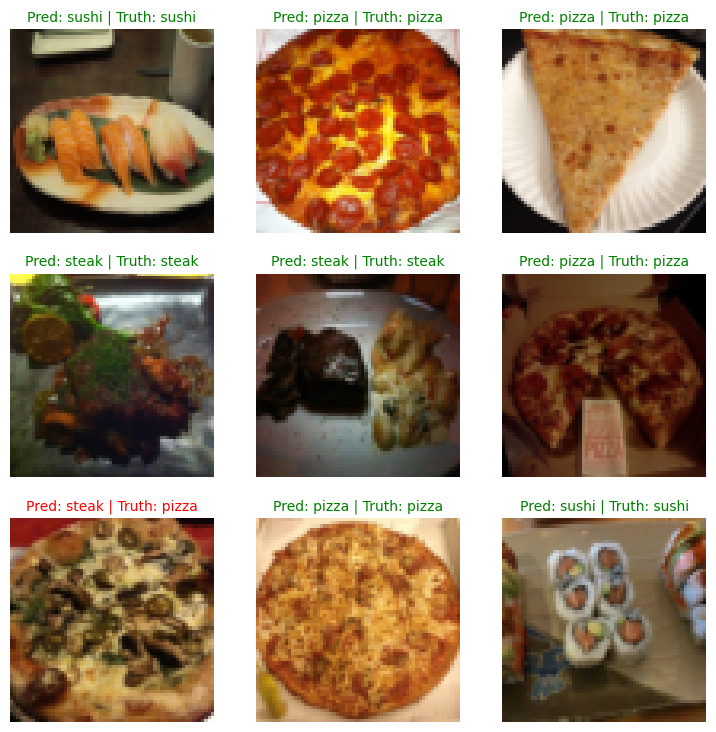

In [19]:
utils.plot_predictions(
    samples=samples,
    lables=lables,
    pred_labels=pred_labels,
    class_names=class_names,
)

### 3.10 Evaluation with confusion matrix


In [20]:
y_preds = engine.evaluation_step(
    model=model_0,
    data_loader=test_dataloader_v0,
    activation_fn=activation_fn,
    device=device,
)

Making predictions:   0%|          | 0/24 [00:00<?, ?it/s]

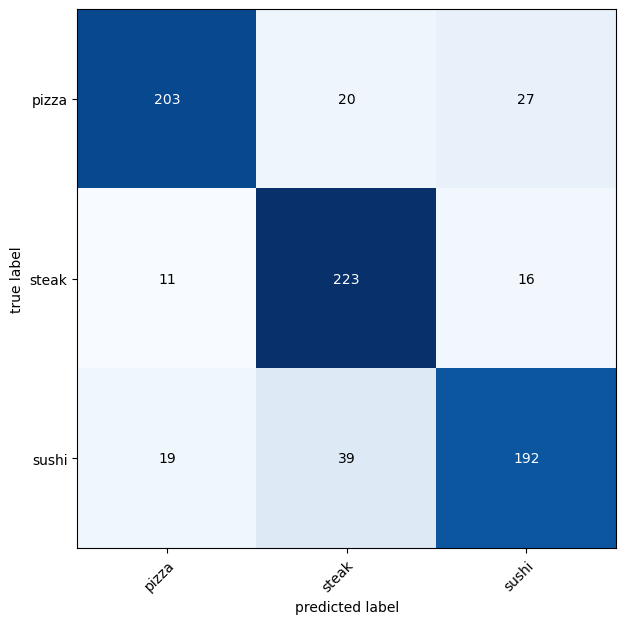

In [21]:
cm = multiclass_confusion_matrix(
    input=y_preds,
    target=torch.tensor(test_data_v0.targets),
    num_classes=NUM_CLASSES,
)
fig, ax = plot_confusion_matrix(cm.numpy(), class_names=class_names, figsize=(10, 7))